In [1]:
import matplotlib.pyplot as plt #basic plotting
import plotly.express as px #interactive plots
import seaborn as sns #visualisation of multidimensional data
import pandas as pd

class GridPlot:
    def __init__(self, n_plots, columns):
        self.n_plots = n_plots
        self.rows = n_plots // columns
        if n_plots % columns > 0:
            self.rows += 1
        self.fig, self.axes = plt.subplots(self.rows, columns, figsize=(columns*5, self.rows*3))
        self.axes = self.axes.ravel()
        self.fig.tight_layout()
        self.fig.subplots_adjust(hspace=0.3)
    def get_figure(self):
        return self.fig
    def get_axes(self):
        return self.axes

# Exploratory Data Analysis

In [2]:
gwl = pd.read_csv("data/gwl.csv", parse_dates=True, index_col=0)
px.line(gwl).show()

In [3]:
from scipy.signal import periodogram
f_dfs = []
for column in gwl.columns:
    f, p = periodogram(gwl[column].dropna(), fs=1/(7/365), nfft=5000) # fs - tuning frequency unit, nfft - tuning frequency resolution
    f_dfs.append(pd.DataFrame({"frequency": f, "power": p, "dataset": column}))
f_df = pd.concat(f_dfs)
f_df = f_df.pivot(index="frequency", columns="dataset", values="power")[gwl.columns] # [gwl.columns] needed to preserve the order of columns
px.line(f_df, range_x=[0, 2]).show()

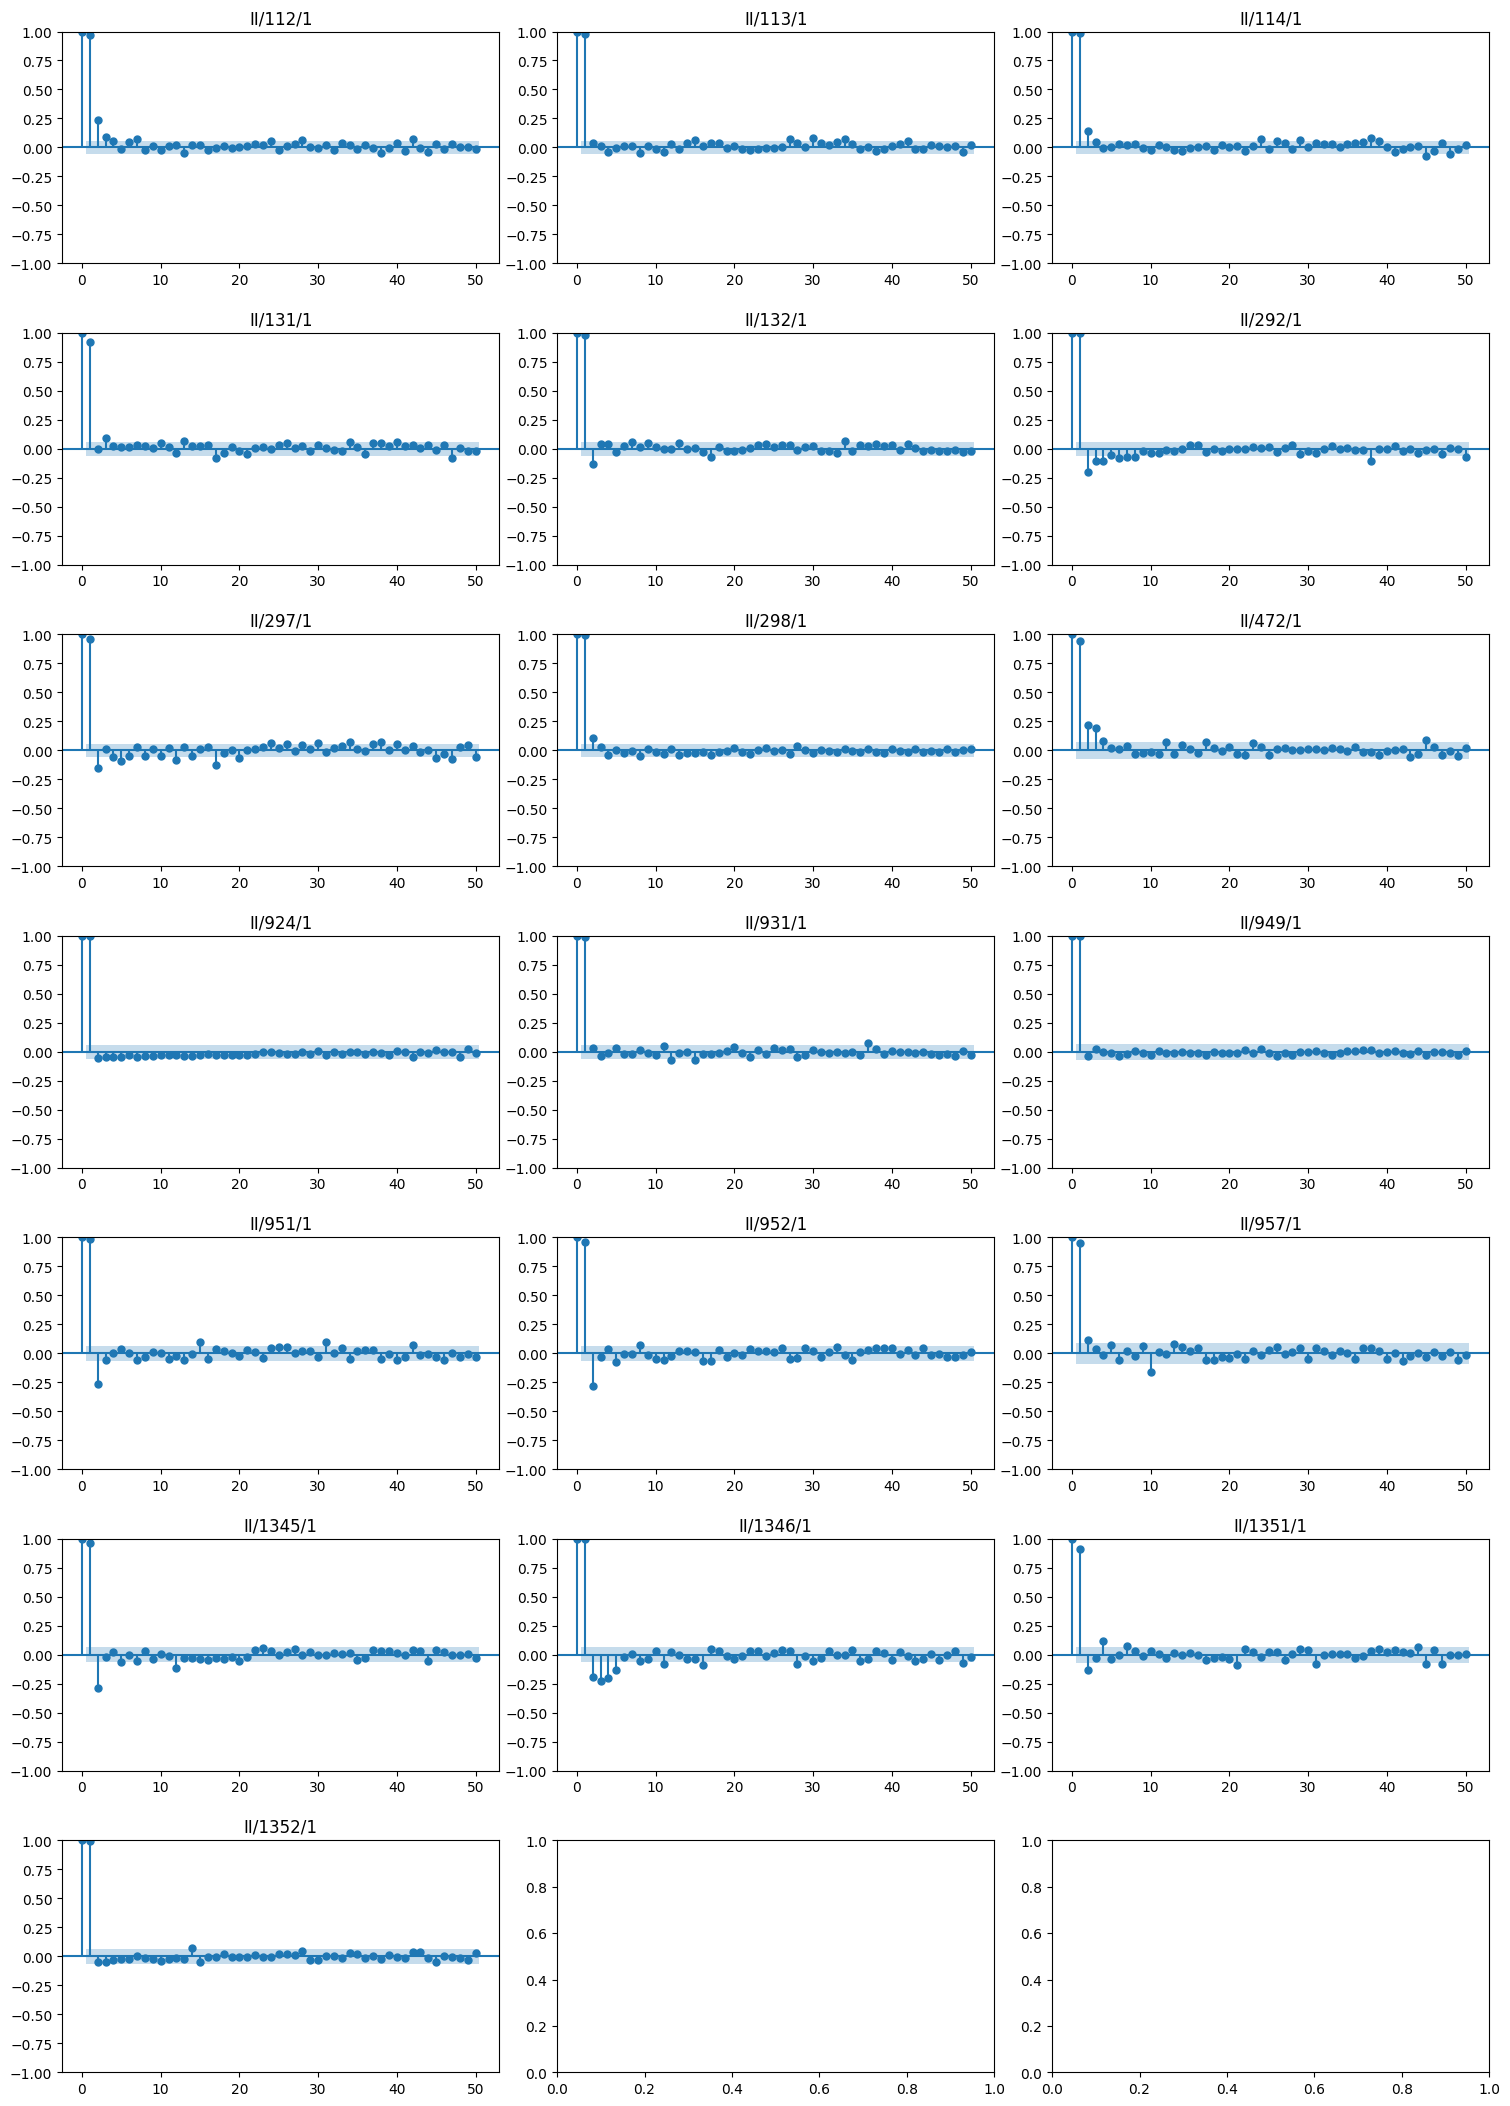

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
grid_plot = GridPlot(len(gwl.columns), 3)
for c, ax in zip(gwl.columns, grid_plot.get_axes()):
    plot_pacf(gwl[c].dropna().values, lags=50, ax=ax)
    ax.set_title(c)
plt.show()

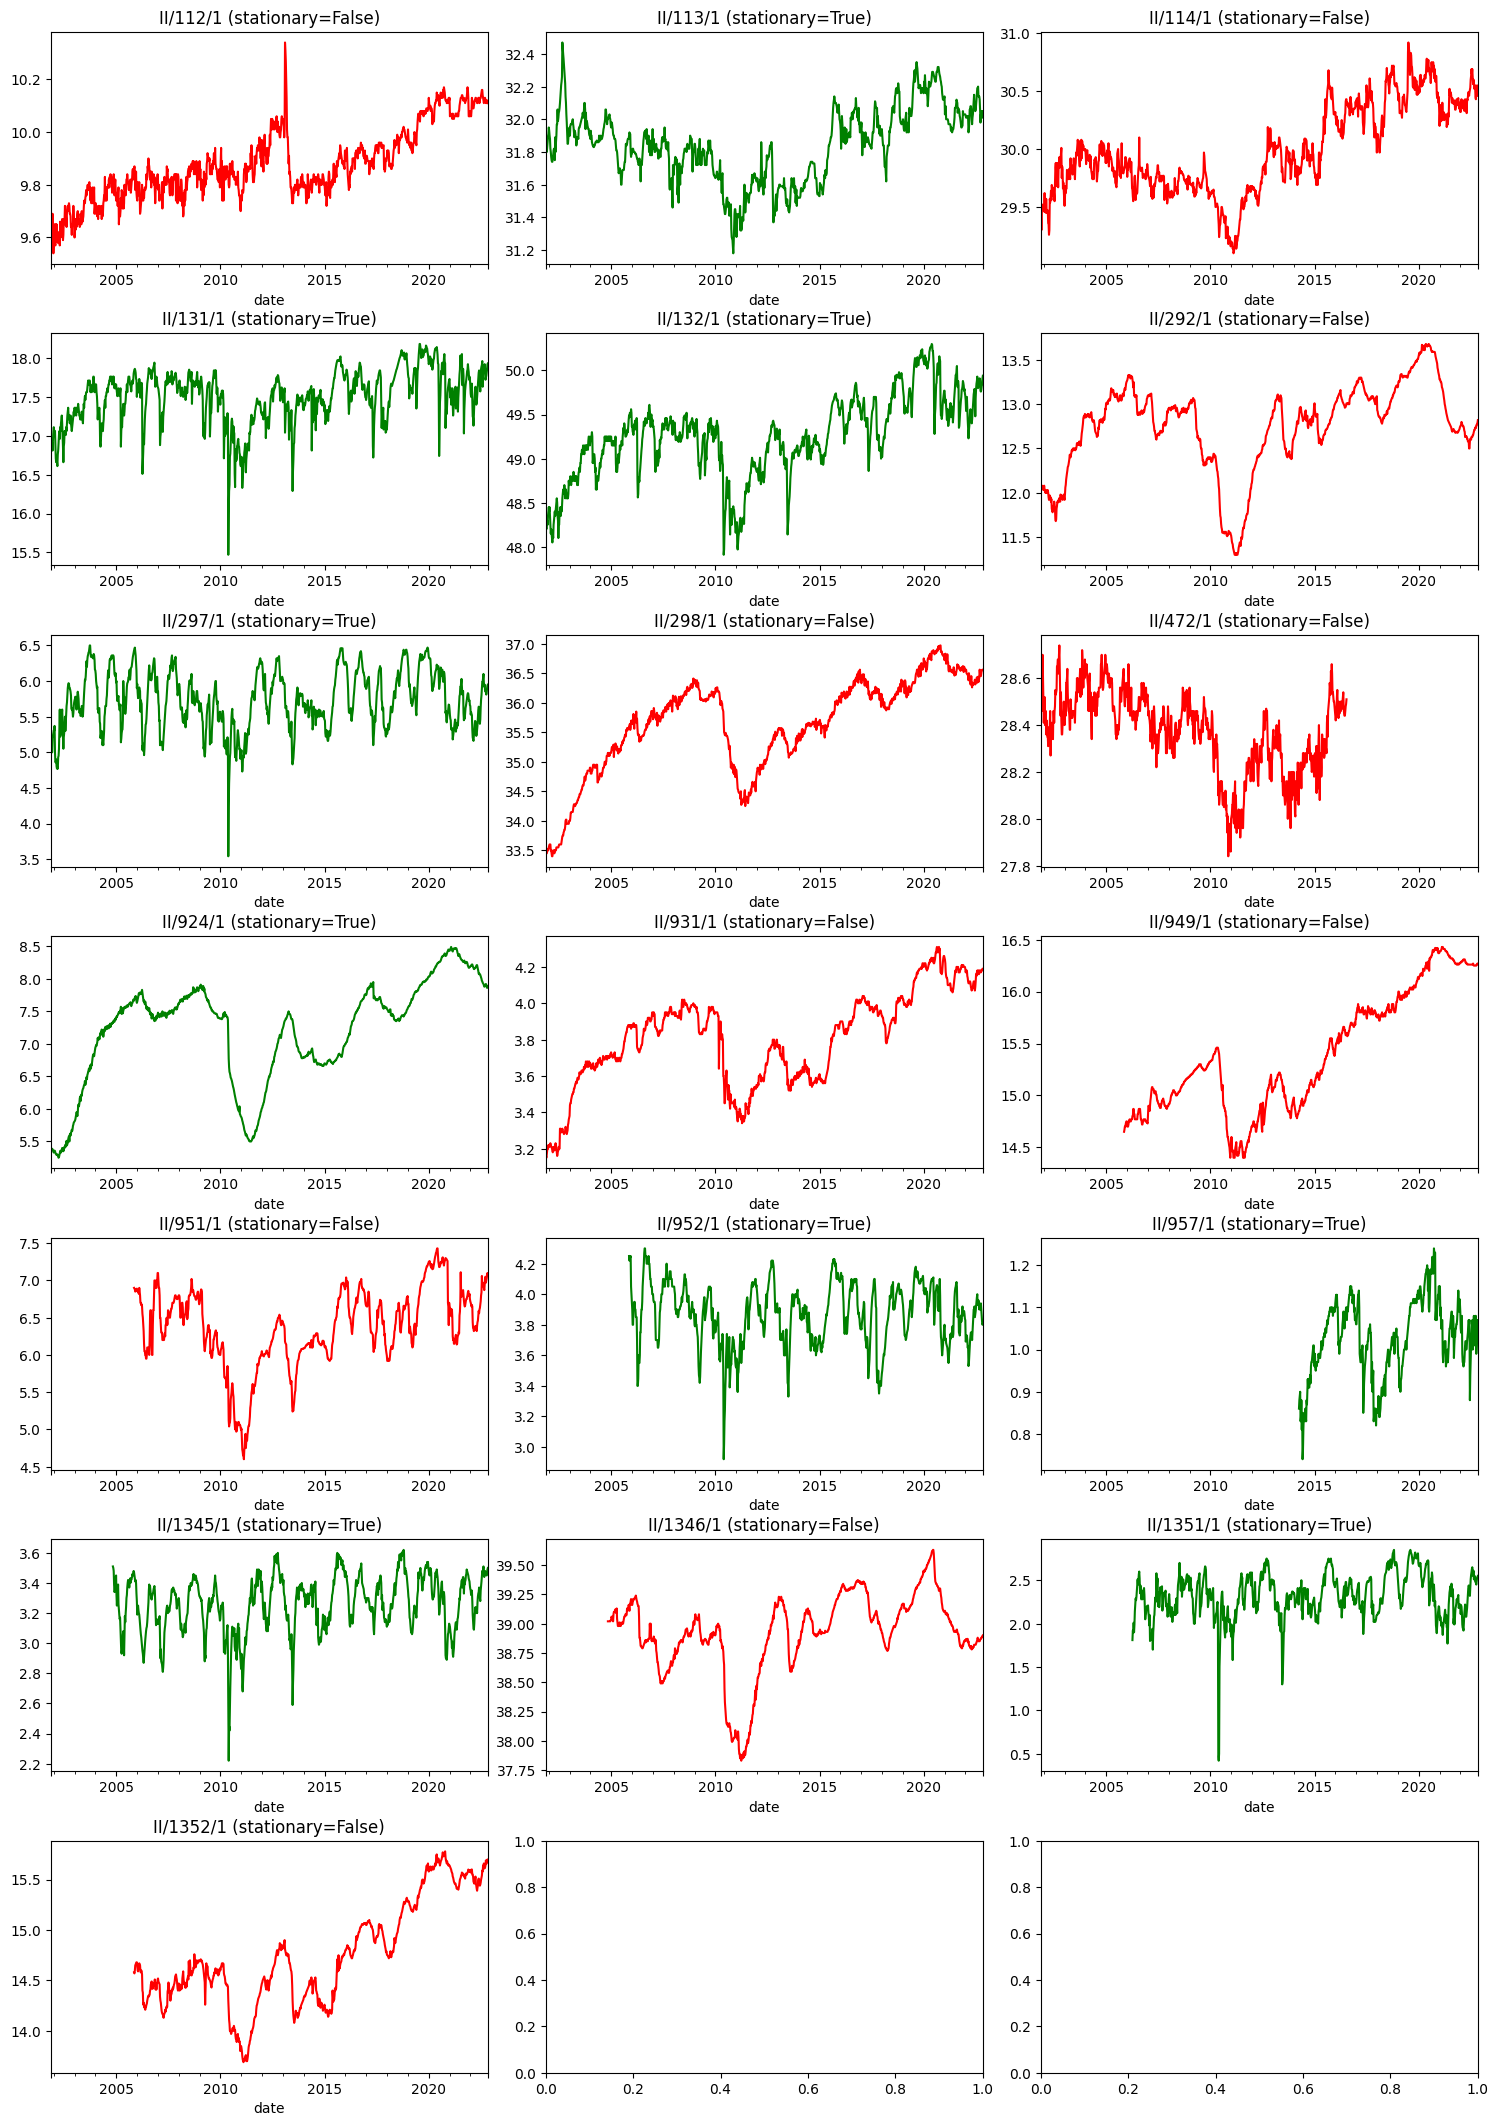

In [5]:
from statsmodels.tsa.stattools import adfuller
# display(pd.DataFrame(gwl.apply(lambda x: adfuller(x.dropna())[1] < 0.05)).T)
is_stationary = gwl.apply(lambda x: adfuller(x.dropna())[1] < 0.05)
grid_plot = GridPlot(len(gwl.columns), 3)
for c, ax in zip(gwl.columns, grid_plot.get_axes()):
    color = "green" if is_stationary[c] else "red"
    gwl[c].plot(ax=ax, title=c, color=color)
    ax.set_title(f"{c} (stationary={is_stationary[c]})")
plt.show()

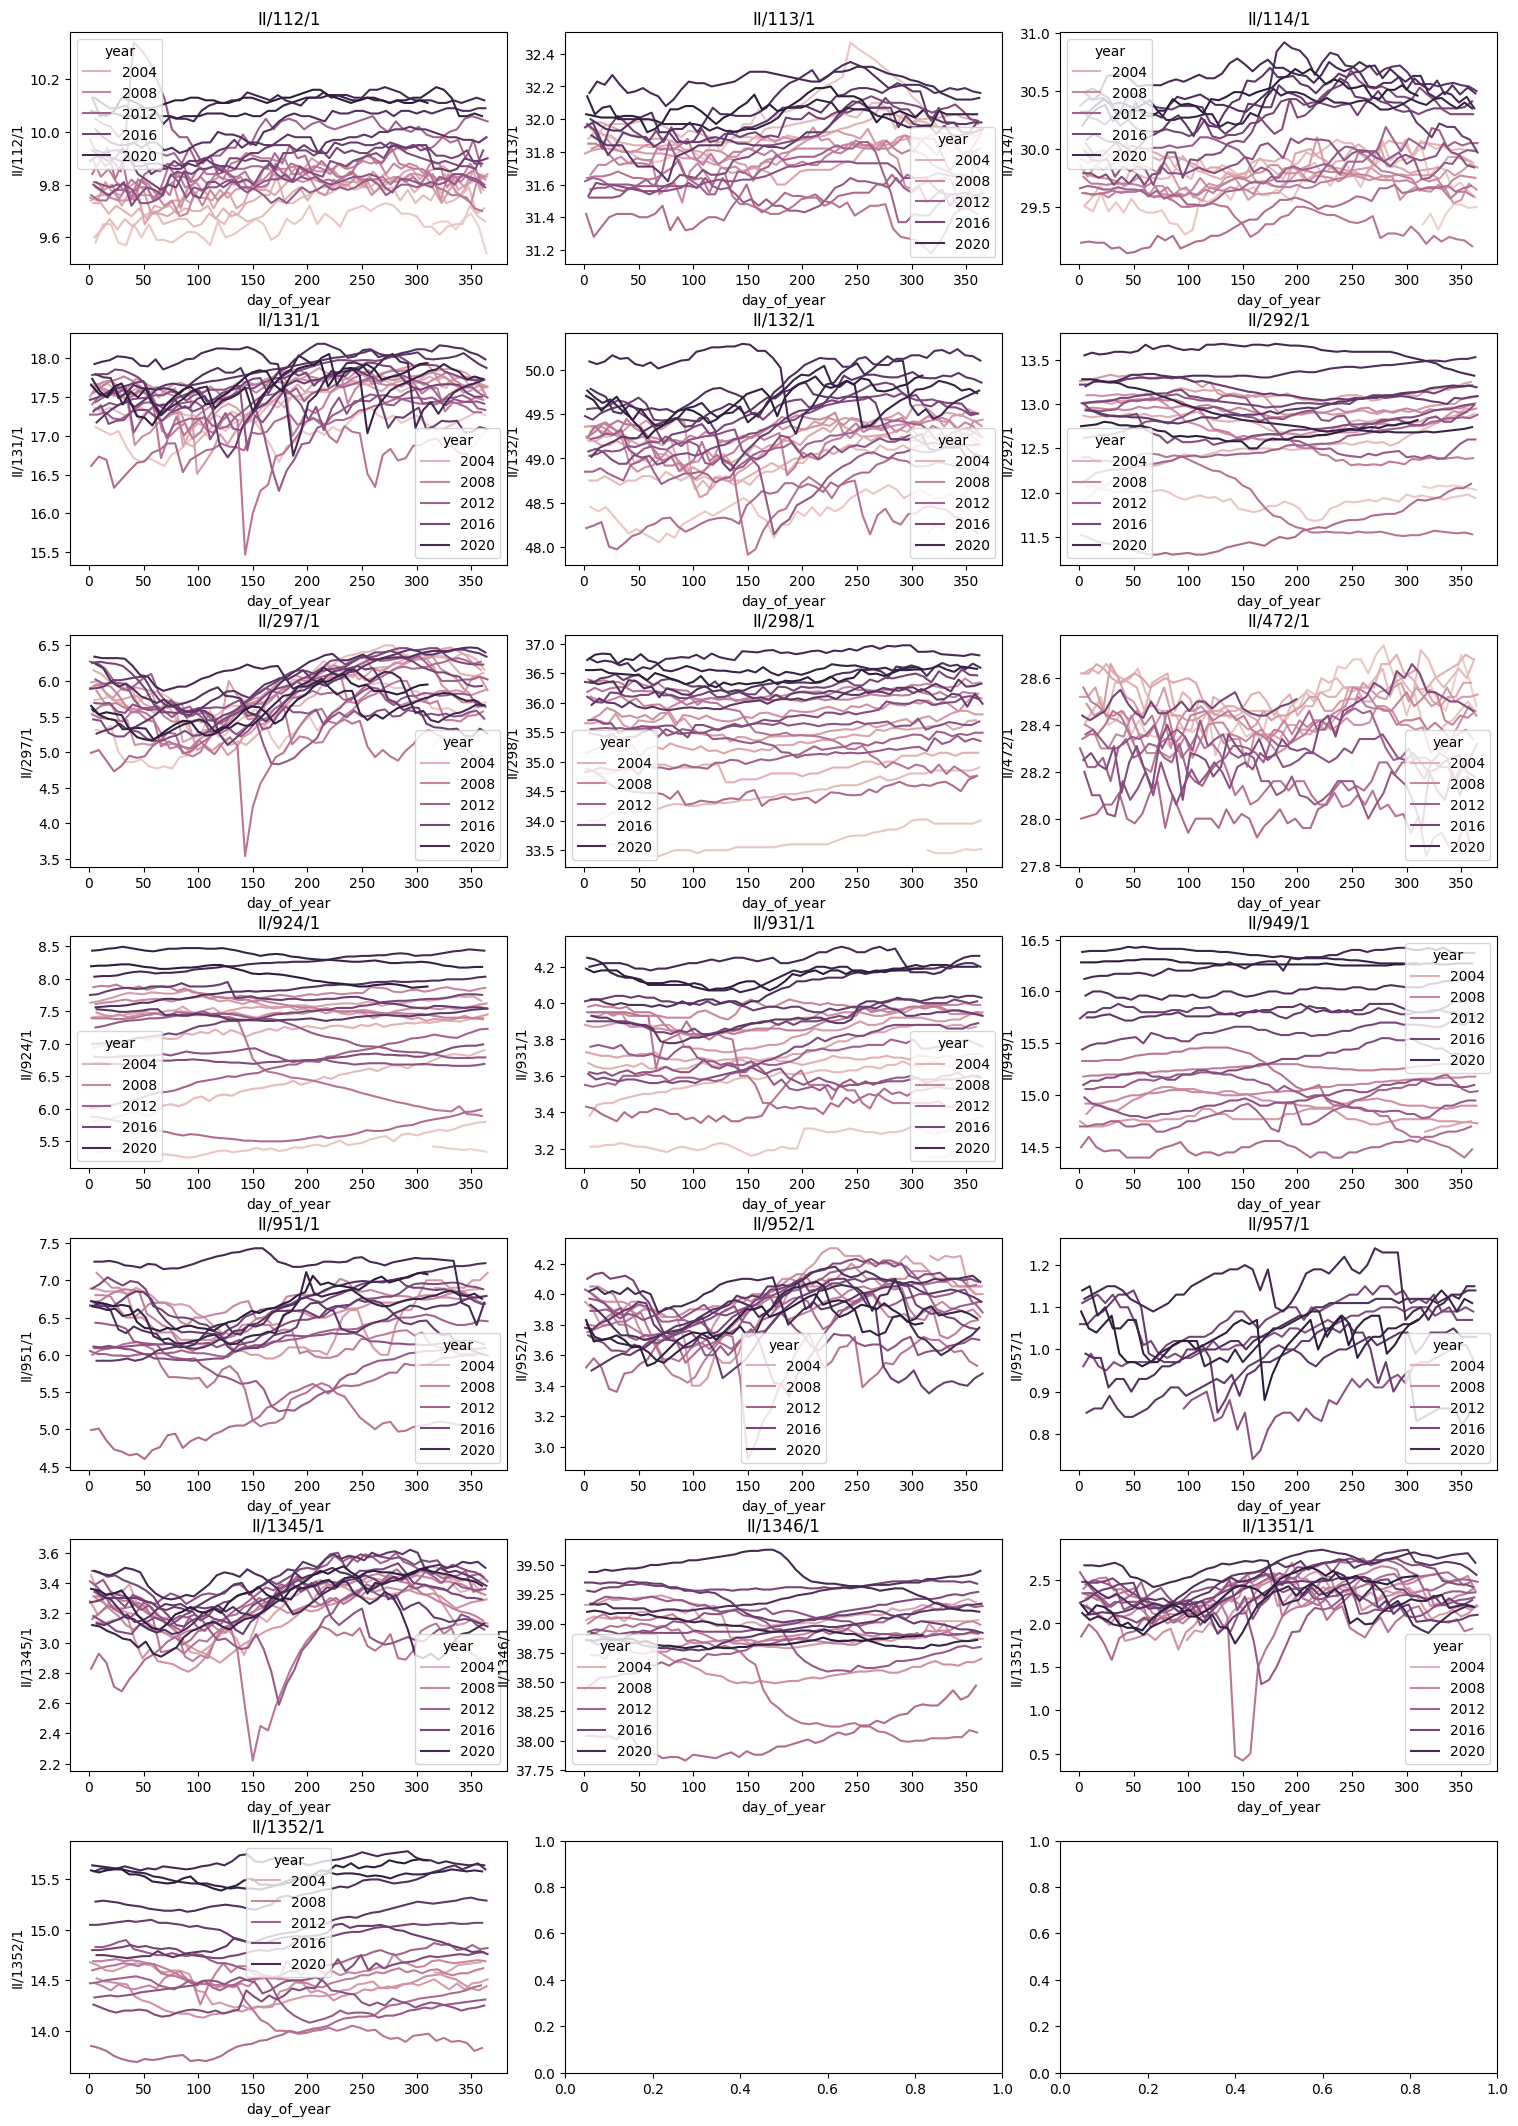

In [8]:
grid_plot = GridPlot(len(gwl.columns), 3)
for c, ax in zip(gwl.columns, grid_plot.get_axes()):
    tmp_df = gwl[[c]].copy()
    tmp_df["day_of_year"] = tmp_df.index.dayofyear
    tmp_df["year"] = tmp_df.index.year
    sns.lineplot(x = tmp_df["day_of_year"], y = tmp_df[c], hue=tmp_df["year"], color="black", ax=ax)
    ax.set_title(c)
plt.show()

# Feature Engineering